Exercício baseado no problema publicado no Kaggle: https://www.kaggle.com/chrizzles/swiss-banknote-conterfeit-detection

**Objetivo:** desenvolver um modelo de classificação capaz de identificar dinheiro falso baseado nas dimensões de uma nota

**Proposta:**
- Efetuar uma análise exploratória dos dados do dataset
- Identificar possíveis enviesamento dos dados
- Realizar testes de hipóteses analisando a variância dos dados
- Testes de normalidade
- Identificar possíveis correlações
- Se necessário, aplicar técnicas de geração de amostras artificiais
- Aplicar técnicas de amostragem que diminuam ao máximo um possível overfitting
- Aplicar técnicas de normalização e regularização, onde aplicável
- Descobrir qual algoritmo tem o melhor desempenho entre Naïve Bayes, Regressão Logística, Árvore de decisão, Floresta Aleatória e SVC
- Usar técnicas de validação cruzada
- Validar resultado com matriz de confusão
- Analisar o grau de variação entre os resutados de teste

Contato pelo Linkedin: https://bit.ly/3tsOnU3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
import itertools
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import skewnorm
from scipy.stats import shapiro
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore")
abs_path = os.getcwd()

# 1. Obtém o dataset através da API do Kaggle

In [2]:
parquet_file = "banknotes.parquet"
csv_file = "banknotes.csv"
zip_file = "swiss-banknote-conterfeit-detection.zip"

if os.path.isfile(parquet_file):
    print ("There is a parquet file!!!")
    dataset = pd.read_parquet(parquet_file)
else:
    """
    Obtém o dataset compactado em .zip, 
    extrai o arquivo .csv,
    deleta o arquivo .zip
    carrega o arquivo no jupyter,
    deleta o arquivo .csv,
    e gera um arquivo .parquet
    """
    print ("There is no file")
    !kaggle datasets download -d chrizzles/swiss-banknote-conterfeit-detection
    with zipfile.ZipFile(zip_file,"r") as zip_ref:
        zip_ref.extractall(abs_path)
    os.remove(zip_file)
    dataset = pd.read_csv(csv_file)
    dataset.to_parquet(parquet_file, engine='pyarrow')
    os.remove(csv_file)
    
dataset

There is a parquet file!!!


,conterfeit,Length,Left,Right,Bottom,Top,Diagonal
0,0,214.8,131.0,131.1,9.0,9.7,141.0
1,0,214.6,129.7,129.7,8.1,9.5,141.7
2,0,214.8,129.7,129.7,8.7,9.6,142.2
3,0,214.8,129.7,129.6,7.5,10.4,142.0
4,0,215.0,129.6,129.7,10.4,7.7,141.8
...,...,...,...,...,...,...,...
195,1,215.0,130.4,130.3,9.9,12.1,139.6
196,1,215.1,130.3,129.9,10.3,11.5,139.7
197,1,214.8,130.3,130.4,10.6,11.1,140.0
198,1,214.7,130.7,130.8,11.2,11.2,139.4


# 2. Análise Exploratória dos Dados

**análise:** através do resultado "false" obtido abaixo, foi provado que:
- Todos os elementos possuem todos os dados, portanto não se faz necessário a remoção de nenhum deles da base de dados, bem como não se faz necessário utilizar nenhuma técnica de preenchimento de dado (ex.: interpolação, média, moda e etc.).
- Não há colunas com excesso de dados nulos, portanto, se for necessário eliminar alguma coluna, não será por este motivo, mas simpor algum outro como baixa correlação com a variável de resposta.

**Contagem de dados nulos por coluna**

In [3]:
dataset.isnull().sum()

conterfeit    0
Length        0
Left          0
Right         0
Bottom        0
Top           0
Diagonal      0
dtype: int64

**Tipagem das colunas**

In [4]:
dataset.dtypes

conterfeit      int64
Length        float64
Left          float64
Right         float64
Bottom        float64
Top           float64
Diagonal      float64
dtype: object

**análise:** abaixo é possível notar a necessidade da normalização das variáveis explicativas, e que elas são variáveis contínuas.

In [5]:
dataset.describe()

,conterfeit,Length,Left,Right,Bottom,Top,Diagonal
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.500000,214.896000,130.121500,129.956500,9.417500,10.650500,140.483500
std,0.501255,0.376554,0.361026,0.404072,1.444603,0.802947,1.152266
min,0.000000,213.800000,129.000000,129.000000,7.200000,7.700000,137.800000
25%,0.000000,214.600000,129.900000,129.700000,8.200000,10.100000,139.500000
50%,0.500000,214.900000,130.200000,130.000000,9.100000,10.600000,140.450000
75%,1.000000,215.100000,130.400000,130.225000,10.600000,11.200000,141.500000
max,1.000000,216.300000,131.000000,131.100000,12.700000,12.300000,142.400000


**análise:** a coluna da variável de resposta, 'conterfeit', está perfeitamente balanceada entre as duas classes fornecidas. Portanto, não é necessário nenhuma técnica para remover ou criar elementos artificiais devido a algum desbalanceamento entre as classes.

In [6]:
np.unique(dataset['conterfeit'], return_counts=True)

(array([0, 1], dtype=int64), array([100, 100], dtype=int64))

**análise:** os gráficos de distribuição abaixo também provam que se faz necessário a normalização das variáveis explicativas. Além de mostrar a variedade de tipos de distribuições entre elas: bimodal, normal, enviesada à direita e à esquerda

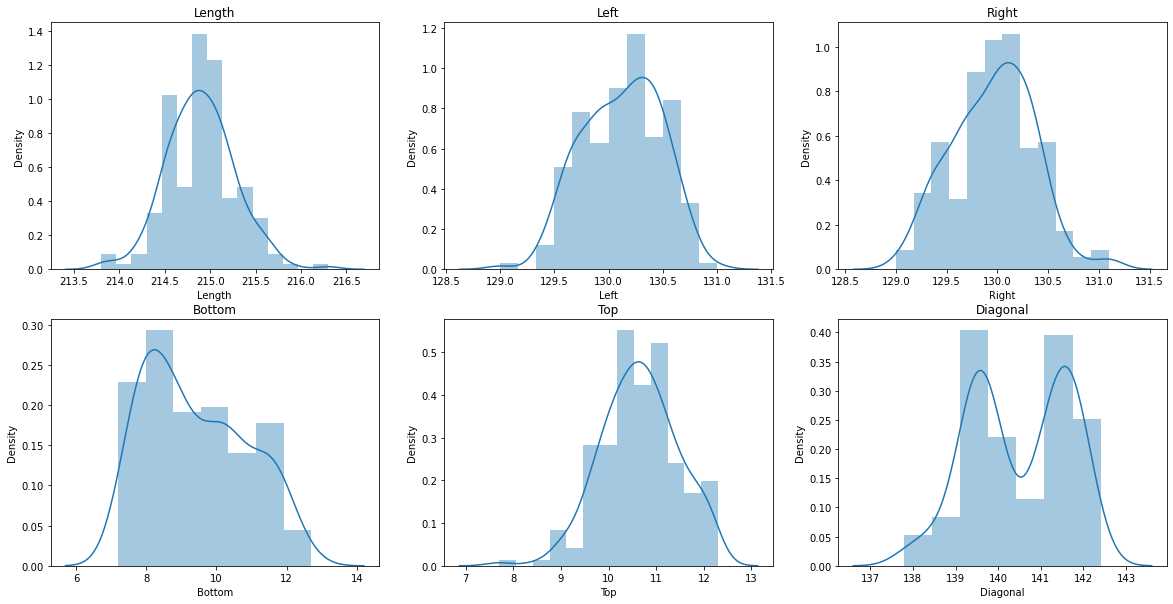

In [7]:
x = dataset.iloc[:,1:]
y = dataset.iloc[:,:1]

plt.figure(figsize=(20,10))
for count, column in enumerate(x.columns):
    plt.subplot(2, len(x.columns)/2, count+1)
    plt.title(column)
    plt.subplot(sns.distplot(dataset[column]))
plt.show()
plt.close()

**análise:** os box plots abaixo mostram que existem alguns outliers.

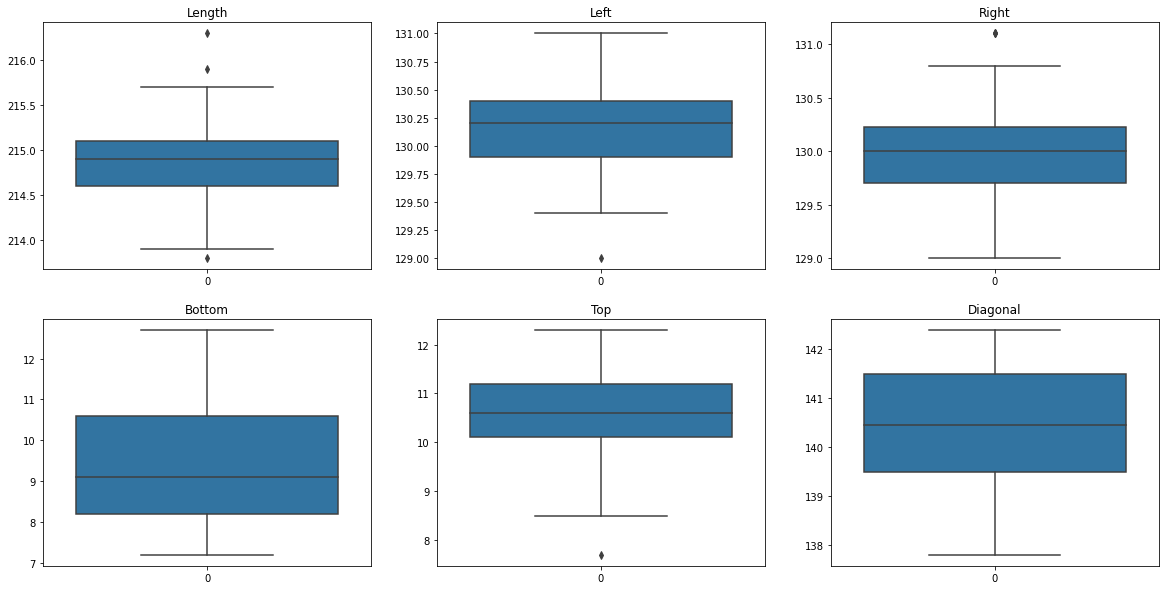

In [8]:
plt.figure(figsize=(20,10))
for count, column in enumerate(x.columns):
    plt.subplot(2, len(x.columns)/2, count+1)
    plt.title(column)
    plt.subplot(sns.boxplot(data=dataset[column]))
plt.show()
plt.close()

**análise:** quanto a normalidade, mais detalhes podem ser obtidos nos gráficos QQ abaixo com o valor de alpha ajustado para 95%

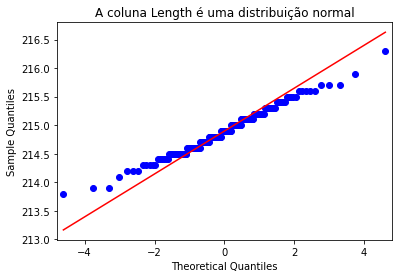

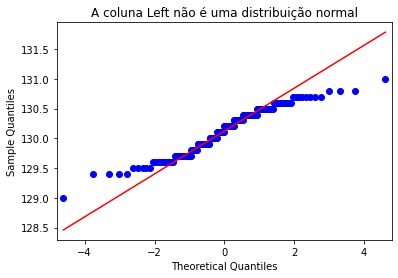

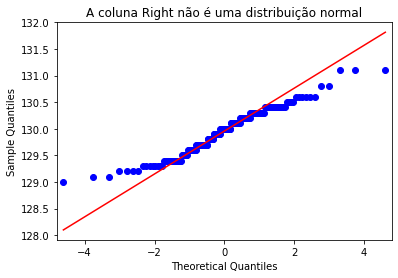

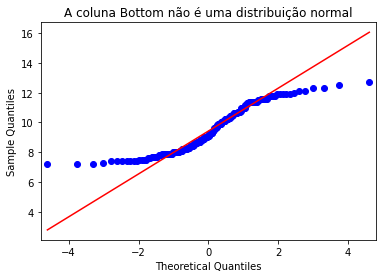

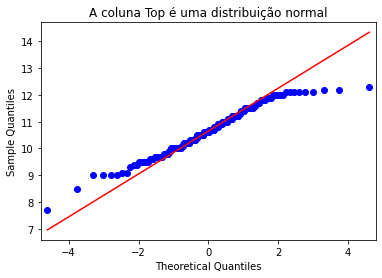

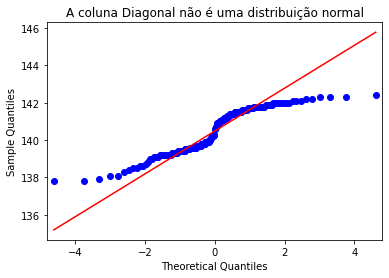

In [18]:
def isNormalDist(column, p):
    alpha = 0.05
    afirmative_text = 'A coluna {} é uma distribuição normal'.format(column)
    negative_text = 'A coluna {} não é uma distribuição normal'.format(column)
    return afirmative_text if p > alpha else negative_text

for column in x.columns:
    _, p = shapiro(dataset[column])
    fig = sm.qqplot(dataset[column], stats.t, distargs=(4,), line = 's')
    plt.title(isNormalDist(column, p))
plt.show()

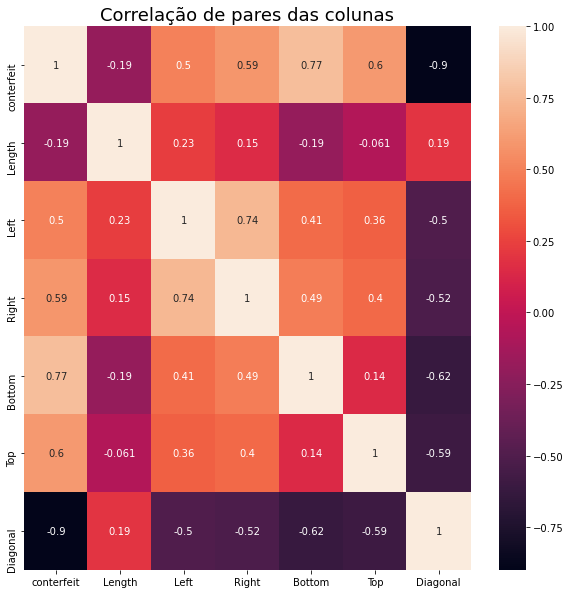

In [10]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.title("Correlação de pares das colunas", fontsize = 18)
ax = sns.heatmap(dataset.corr(), annot = True)

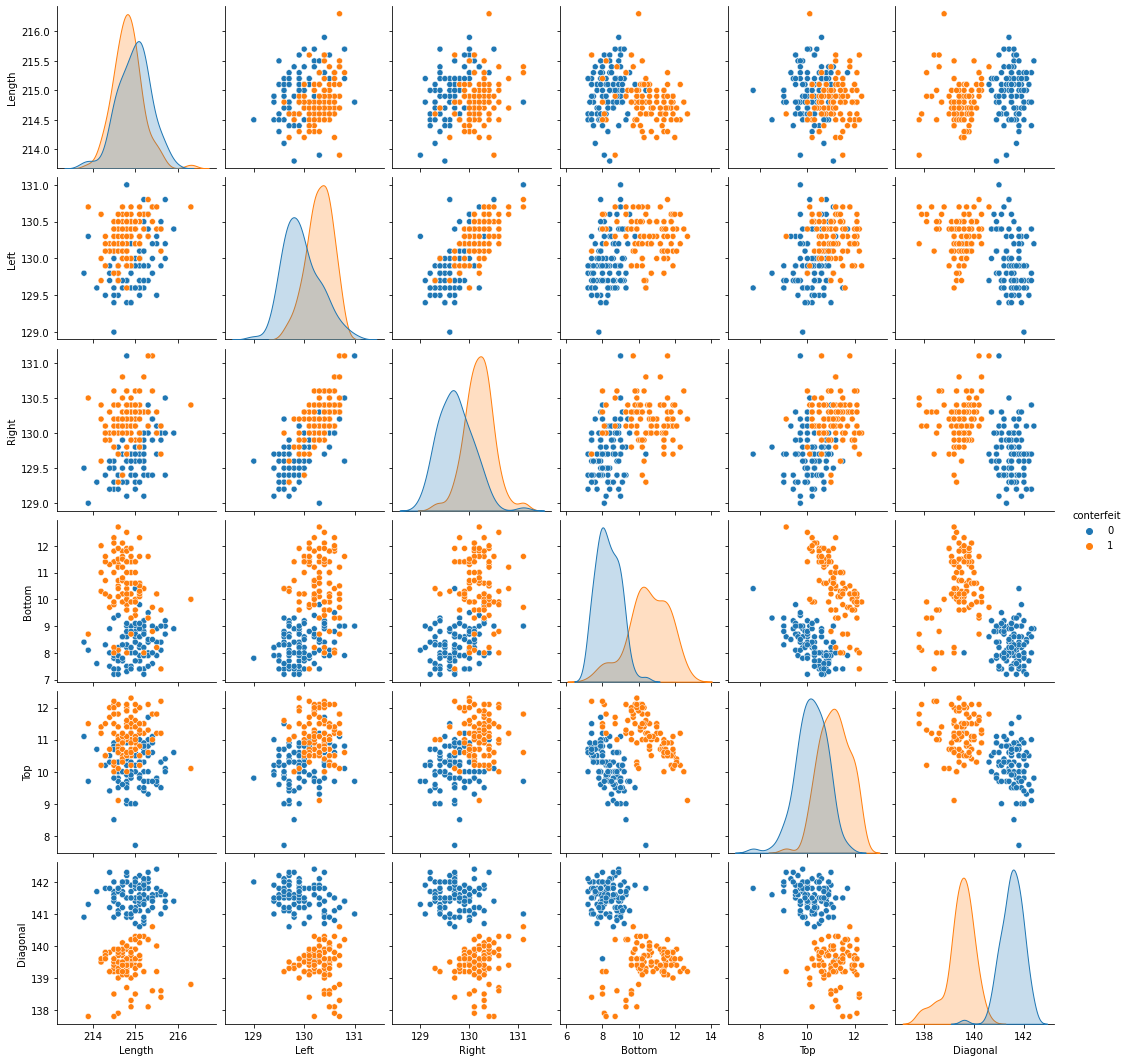

In [11]:
sns.pairplot(dataset, hue = "conterfeit")
plt.show()

# 3. Treino do modelo - sem tratamento dos enviesamentos e sem testes de hipóteses, apenas para existir uma referência de melhoria de modelo

**Variáveis explicativas**

In [12]:
x.head()

,Length,Left,Right,Bottom,Top,Diagonal
0,214.8,131.0,131.1,9.0,9.7,141.0
1,214.6,129.7,129.7,8.1,9.5,141.7
2,214.8,129.7,129.7,8.7,9.6,142.2
3,214.8,129.7,129.6,7.5,10.4,142.0
4,215.0,129.6,129.7,10.4,7.7,141.8


**Variável de resposta**

In [13]:
y.head()

,conterfeit
0,0
1,0
2,0
3,0
4,0


Média Precisão:
	Naïve Bayes              : 0.99111%
	Regressão Logística      : 0.99278%
	Floresta Aleatória       : 0.99167%
	Árvore de decisão        : 0.98%
	SVC                      : 0.98944%
	kNN                      : 0.98722%
Desvio Padrão:
	Naïve Bayes              : 0.0093624
	Regressão Logística      : 0.0082589
	Floresta Aleatória       : 0.0083333
	Árvore de decisão        : 0.013878
	SVC                      : 0.010077
	kNN                      : 0.013391
Coeficiente de variação:
	Naïve Bayes              : 0.0094464
	Regressão Logística      : 0.008319
	Floresta Aleatória       : 0.0084034
	Árvore de decisão        : 0.014161
	SVC                      : 0.010184
	kNN                      : 0.013564


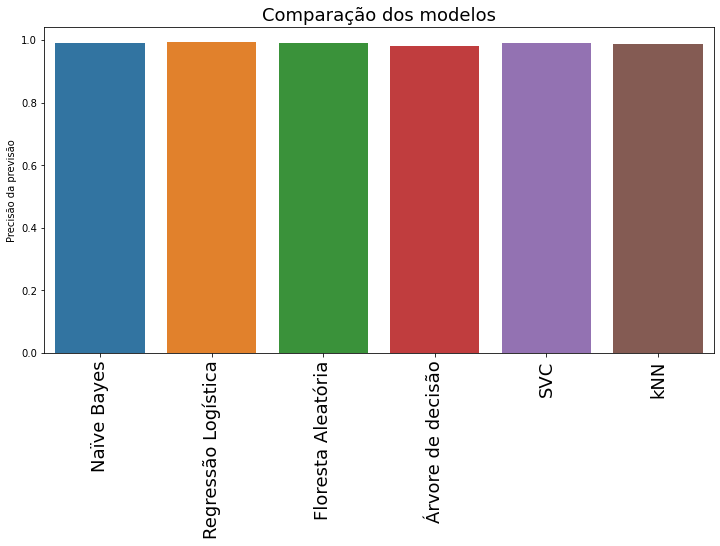

Intervalo de confiança - Naïve Bayes         : (0.9877036119546867, 0.9945186102675356)
Intervalo de confiança - Regressão Logística : (0.9897718902680939, 0.9957836652874621)
Intervalo de confiança - Floresta Aleatória  : (0.9886336985423001, 0.9946996347910335)
Intervalo de confiança - Árvore de decisão   : (0.974949098702433, 0.985050901297567)
Intervalo de confiança - SVC                 : (0.985776907174052, 0.9931119817148372)
Intervalo de confiança - kNN                 : (0.9823484564553482, 0.9920959879890965)


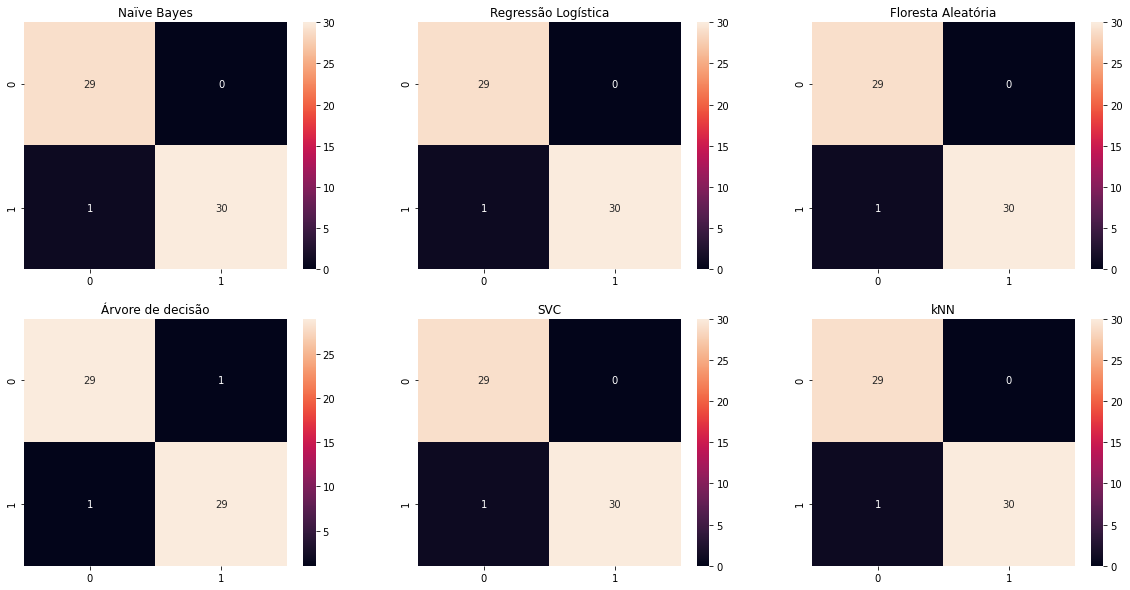

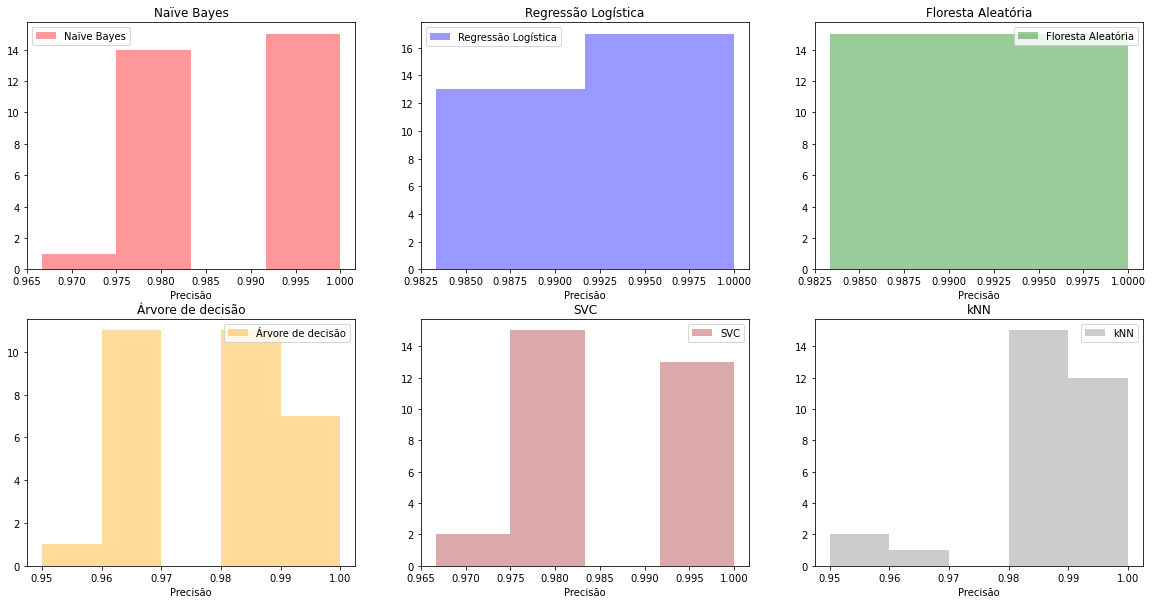

In [14]:
def train(x, y, train_loop):
    resultados_naive_bayes = []
    resultados_logistica = []
    resultados_forest = []
    resultados_decision_tree = []
    resultados_svc = []
    resultados_knn = []
    
    previsao_naive_bayes = 0
    previsao_logistica = 0
    previsao_forest = 0
    previsao_decision_tree = 0
    previsao_svc = 0
    previsao_knn = 0
    
    for i in range(train_loop):
        x_train, x_test, y_train, y_test = train_test_split(x, 
                                                            y, 
                                                            test_size=0.3,
                                                            stratify = y,
                                                            random_state = i)
        st = StandardScaler()
        x_train = st.fit_transform(x_train)
        x_test = st.fit_transform(x_test)

        naive_bayes = GaussianNB()
        naive_bayes.fit(x_train, y_train)
        previsao_naive_bayes = naive_bayes.predict(x_test)
        resultados_naive_bayes.append(accuracy_score(y_test, previsao_naive_bayes))

        logistica = LogisticRegression()
        logistica.fit(x_train, y_train)
        previsao_logistica = logistica.predict(x_test)
        resultados_logistica.append(accuracy_score(y_test, previsao_logistica))

        random_forest = RandomForestClassifier()
        random_forest.fit(x_train, y_train)
        previsao_forest = random_forest.predict(x_test)
        resultados_forest.append(accuracy_score(y_test, previsao_forest))
        
        decision_tree = DecisionTreeClassifier()
        decision_tree.fit(x_train, y_train)
        previsao_decision_tree = decision_tree.predict(x_test)
        resultados_decision_tree.append(accuracy_score(y_test, previsao_decision_tree))
        
        svc = SVC()
        svc.fit(x_train, y_train)
        previsao_svc = svc.predict(x_test)
        resultados_svc.append(accuracy_score(y_test, previsao_svc))
        
        knn = KNeighborsClassifier()
        knn.fit(x_train, y_train)
        previsao_knn = knn.predict(x_test)
        resultados_knn.append(accuracy_score(y_test, previsao_knn))
        
    return [[
                np.array(resultados_naive_bayes), 
                np.array(resultados_logistica), 
                np.array(resultados_forest),
                np.array(resultados_decision_tree),
                np.array(resultados_svc),
                np.array(resultados_knn),
            ],
            [
                previsao_naive_bayes,
                previsao_logistica,
                previsao_forest,
                previsao_decision_tree,
                previsao_svc,
                previsao_knn,
            ],
            y_test]

def plot_algorithms_scores_comparison(algoritmos, scores):
    plt.figure(figsize = (12,6)) 
    mean_score_list = []
    [mean_score_list.append(algor_score_list.mean()) for algor_score_list in scores]
    ax = sns.barplot(algoritmos,mean_score_list)
    ax.set_xticklabels(algoritmos, fontsize = 18, rotation = 90)
    plt.title("Comparação dos modelos", fontsize = 18)
    plt.ylabel("Precisão da previsão")
    plt.show()
    plt.close()
    
def calculate_plot_confusion_matrix(previsoes, y_test, algoritmos):
    plt.figure(figsize=(20,10))
    for index, (score,algoritmo) in enumerate(zip(list(previsoes),algoritmos)):
        plt.subplot(2, len(previsoes)/2, index+1)
        plt.title(algoritmo)
        plt.subplot(sns.heatmap(confusion_matrix(previsoes[index], y_test), annot=True))
        
def plot_confusion_matrix(matrix, algoritmos):
    plt.figure(figsize=(20,10))
    for index, (score,algoritmo) in enumerate(zip(list(matrix),algoritmos)):
        plt.subplot(2, len(matrix)/2, index+1)
        plt.title(algoritmo)
        plt.subplot(sns.heatmap(matrix[index], annot=True))
    
def plot_scores_distplot(scores, algoritmos):
    plt.figure(figsize=(20,10))
    colors = ["red", "blue", "green", "orange", "brown", "gray"]

    for (index,(score,algoritmo)), color in zip(enumerate(zip(list(scores),algoritmos)), colors):
        plt.subplot(2, len(scores)/2, index+1)
        plt.title(algoritmo)
        plt.subplot(sns.distplot(score, color=color, label=algoritmo, hist=True, kde=False, axlabel="Precisão"))
        plt.legend();
    
def plot_confidence_interval(scores, algoritmos):
    for score,algoritmo in zip(list(scores),algoritmos):
        print("Intervalo de confiança - {:<20}: {}".format(algoritmo, norm.interval(0.95, score.mean(),stats.sem(score))))
        
def plot_statistics(scores, algoritmos):
    print("Média Precisão:")
    for score,algoritmo in zip(list(scores),algoritmos):
        print("\t{:<25}: {:.5}%".format(algoritmo, score.mean()))
    print("Desvio Padrão:")
    for score,algoritmo in zip(list(scores),algoritmos):
        print("\t{:<25}: {:.5}".format(algoritmo, np.std(score)))
    print("Coeficiente de variação:")
    for score,algoritmo in zip(list(scores),algoritmos):
        print("\t{:<25}: {:.5}".format(algoritmo, stats.variation(score)))
    
def train_and_plot_anslysis(x, y):
    train_loop = 30
    results = train(x, y, train_loop)
    algoritmos = ["Naïve Bayes", "Regressão Logística", "Floresta Aleatória", "Árvore de decisão", "SVC", "kNN"]
    
    #Média, Desvio e Coeficiente
    plot_statistics(results[0], algoritmos)
    
    #Comparação do resultado dos algoritmos
    plot_algorithms_scores_comparison(algoritmos, results[0])
    
    #Intervalo de confiança
    plot_confidence_interval(results[0], algoritmos)
    
    #Matrix de Confusão
    calculate_plot_confusion_matrix(results[1], results[2], algoritmos)
        
    #Variação dos resultados
    plot_scores_distplot(results[0], algoritmos)
    
train_and_plot_anslysis(x, y)

# 4. Validação dos modelos com K-Fold - sem estudo de correlações, sem tratamento dos enviesamentos e sem testes de hipóteses

Média Precisão:
	Naïve Bayes              : 0.99433%
	Regressão Logística      : 0.995%
	Floresta Aleatória       : 0.99183%
	Árvore de decisão        : 0.98117%
	SVC                      : 0.51917%
	kNN                      : 0.99517%
Desvio Padrão:
	Naïve Bayes              : 0.0016997
	Regressão Logística      : 1.1102e-16
	Floresta Aleatória       : 0.0024095
	Árvore de decisão        : 0.0058713
	SVC                      : 0.073384
	kNN                      : 0.00089753
Coeficiente de variação:
	Naïve Bayes              : 0.0017094
	Regressão Logística      : 1.1158e-16
	Floresta Aleatória       : 0.0024293
	Árvore de decisão        : 0.005984
	SVC                      : 0.14135
	kNN                      : 0.00090189


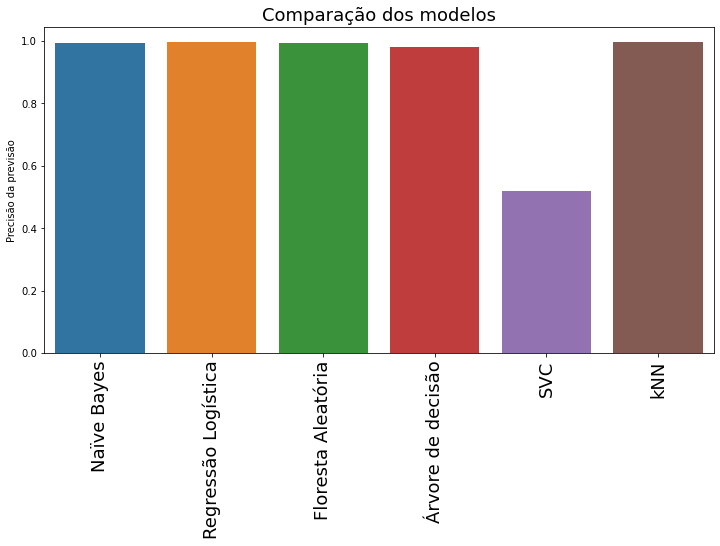

Intervalo de confiança - Naïve Bayes         : (0.9937147267873232, 0.9949519398793432)
Intervalo de confiança - Regressão Logística : (0.995, 0.995)
Intervalo de confiança - Floresta Aleatória  : (0.9909563911027444, 0.9927102755639221)
Intervalo de confiança - Árvore de decisão   : (0.9790297689626585, 0.983303564370675)
Intervalo de confiança - SVC                 : (0.492458286679011, 0.5458750466543223)
Intervalo de confiança - kNN                 : (0.9948400060025766, 0.9954933273307567)


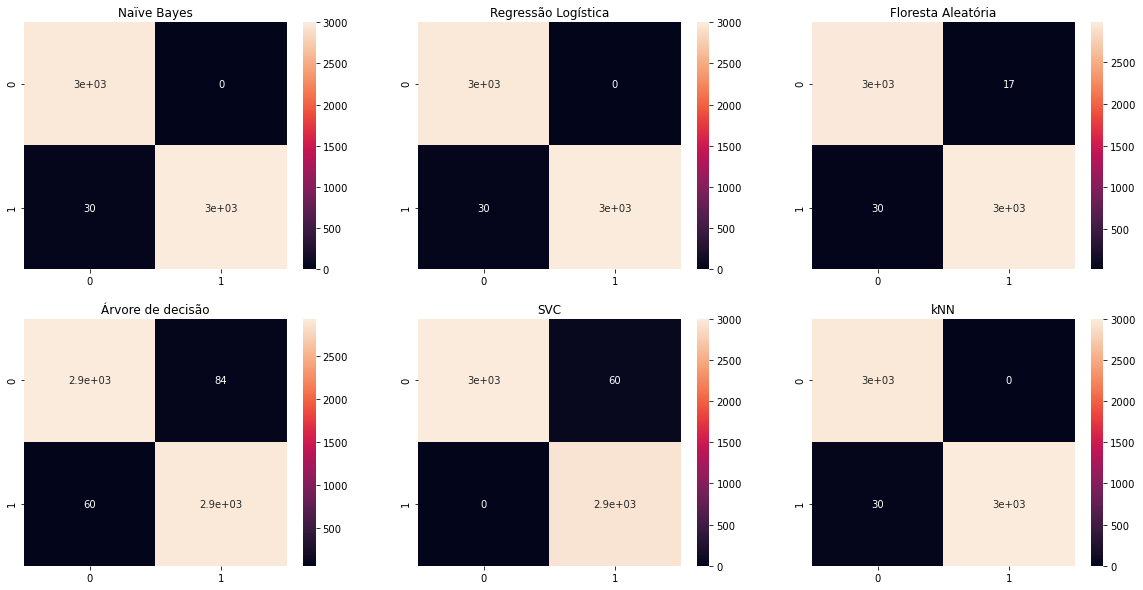

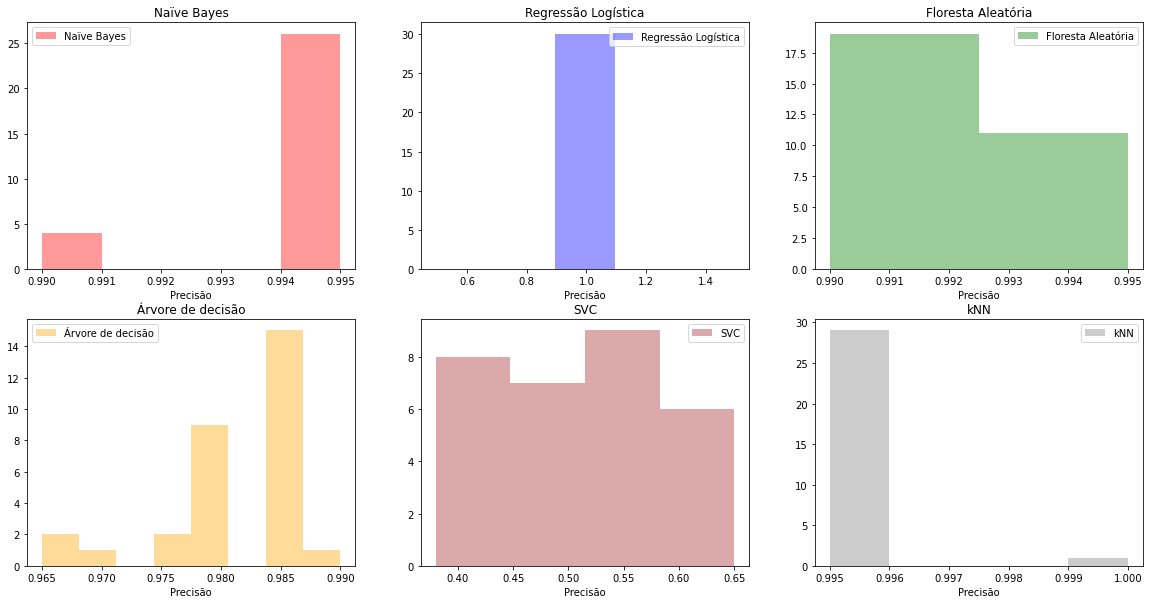

In [15]:
def train_kfold(x, y, train_loop):
    resultados_naive_bayes = []
    resultados_logistic = []
    resultados_forest = []
    resultados_decision_tree = []
    resultados_svc = []
    resultados_knn = []
    confusion_kfold = []

    for i in range(train_loop):
        kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
        
        modelos = [GaussianNB(), 
                   LogisticRegression(), 
                   RandomForestClassifier(), 
                   DecisionTreeClassifier(), 
                   SVC(),
                   KNeighborsClassifier()]

        scores = cross_val_score(modelos[0], x, y, cv = kfold)
        resultados_naive_bayes.append(scores.mean())

        scores = cross_val_score(modelos[1], x, y, cv = kfold)
        resultados_logistic.append(scores.mean())

        scores = cross_val_score(modelos[2], x, y, cv = kfold)
        resultados_forest.append(scores.mean())
        
        scores = cross_val_score(modelos[3], x, y, cv = kfold)
        resultados_decision_tree.append(scores.mean())
        
        scores = cross_val_score(modelos[4], x, y, cv = kfold)
        resultados_svc.append(scores.mean())
        
        scores = cross_val_score(modelos[5], x, y, cv = kfold)
        resultados_knn.append(scores.mean())
        
        if i == 0:
            [confusion_kfold.append(confusion_matrix(cross_val_predict(modelo, x, y, cv=10), y)) for modelo in modelos]
        else:
            for index, modelo in enumerate(modelos):
                confusion_kfold[index] = confusion_kfold[index] + confusion_matrix(cross_val_predict(modelo, x, y, cv=10), y)
    
    return [[np.array(resultados_naive_bayes), 
            np.array(resultados_logistic), 
            np.array(resultados_forest),
            np.array(resultados_decision_tree),
            np.array(resultados_svc),
            np.array(resultados_knn)],
            confusion_kfold]

def train_and_plot_kfold_analysis(x, y):
    algoritmos = ["Naïve Bayes", "Regressão Logística", "Floresta Aleatória", "Árvore de decisão", "SVC", "kNN"]
    train_loop = 30
    
    results_kfold = train_kfold(x, y, train_loop)   

    #Média, Desvio e Coeficiente
    plot_statistics(results_kfold[0], algoritmos)
    
    #Comparação do resultado dos algoritmos
    plot_algorithms_scores_comparison(algoritmos, results_kfold[0])

    #Intervalo de confiança
    plot_confidence_interval(results_kfold[0], algoritmos)
    
    #Matrix de Confusão
    plot_confusion_matrix(results_kfold[1], algoritmos)

    #Variação dos resultados
    plot_scores_distplot(results_kfold[0], algoritmos)
        
train_and_plot_kfold_analysis(x, y)

In [17]:
!jupyter nbconvert --to html --output "notebook_file" "Swiss Banknote Conterfeit Detection.ipynb" --no-input

[NbConvertApp] Converting notebook Swiss Banknote Conterfeit Detection.ipynb to html
[NbConvertApp] Writing 1639047 bytes to notebook_file.html
